### Intro

Это второй ноутбук, здесь мы прогнозируем спрос на товары, не вошедшие в топ-150 по продажам и имеющие в своих временных рядах более 20% пропусков. Для их моделирования мы отталкиваемся от продаж товара по всем магазинам, с одной стороны, и продаж различных товаров в заданном магазине. На данный момент мы успели ввести только эти два типа лаговых переменных. Однако в дальнейшем мы планируем рассмотреть продажи подкатегории и категории, к которым принадлежит товар - это может помочь в прогнозировании товаров, у которых совсем нет истории продаж, а также агрегированные ценовые показатели, возможно, отношение цены товара к средней цене по категории или подкатегории.

Возможно, если какие-то признаки будут особенно успешными, мы поэкспериментируем в их применении и для топ-150 товаров. 

Сейчас все товары, не вошедшие в первую группу, прогнозируются единым пулом. Однако мы также работаем в направлении кластеризации товаров и магазинов, полагая, что если есть группы, имеющие сходные тренды, то прогнозируя их отдельно, модели будут иметь больший успех в выявлении зависимостей.

Ноутбук состоит из следующих частей: предобработка данных, генерация признаков, обучение модели, предсказание. В конце каждой части мы сформулировали промежуточные итоги



In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna
import warnings #для игнорирования предупреждений об ошибках
warnings.filterwarnings("ignore")
# импортируем необходимые функции из библиотеки для генерации признаков
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

C:\Users\algol\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Preprocessing

In [3]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [4]:
sales.shape

(883015, 8)

In [5]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [6]:
#estimate cases where sales in units are zero and in rubles not, or vice versa
zero_nonzero_sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] == 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] != 0))]
zero_nonzero_sales.shape

(66882, 8)

In [7]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [8]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [9]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [10]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.shape

(661192, 5)

In [11]:
#detect top150 item-store pairs
by_pair = oneline.groupby('store_item')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('pr_sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('pr_sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)

pr_sales_in_units        \
                                                                 sum count   
store_item                                                                   
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...           51500.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...           42088.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...           34255.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...           32923.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...           29678.0   352   
...                                                              ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...            5469.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...            5417.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...            5399.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...            5364.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...            5337.0   192   

                                                   pr_sales_in_rub        \
                                                               sum count   
store_item                                                                 
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        879274.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...       1999391.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...       1070819.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...       4187731.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        963222.0   352   
...                                                            ...   ...   
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        324306.0   345   
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...         84293.0   352   
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        643395.0   339   
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        328648.0   351   
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        913631.0   192   

                                                   all_sales_share  
                                                                    
store_item                                                          
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...        0.168569  
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...        0.383311  
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...        0.205291  
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...        0.802847  
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...        0.184663  
...                                                            ...  
f7e6c85504ce6e82442c770f7c8606f0-7a5ebc8af26893...        0.062174  
c81e728d9d4c2f636f067f89cc14862c-5b26f85ccb2303...        0.016160  
42a0e188f5033bc65bf8d78622277c4e-603c32f40317b3...        0.123348  
42a0e188f5033bc65bf8d78622277c4e-d22bb534b7964c...        0.063006  
f7e6c85504ce6e82442c770f7c8606f0-2d4cee78441933...        0.175156  

[150 rows x 5 columns]

In [12]:
#separate top 150
by_pair = by_pair.reset_index()
top150 = by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(150)
no_top150 = by_pair[~by_pair['store_item'].isin(top150['store_item'])]
most_frequent = no_top150[no_top150[('pr_sales_in_units', 'count')] >= 352*0.8]
flagman = pd.concat([top150, most_frequent])
flagman.shape

(857, 6)

In [13]:
#get no flagman pairs
rest = by_pair[~by_pair['store_item'].isin(flagman['store_item'])]
rest.shape

(5273, 6)

In [14]:
oneline = oneline.reset_index()
oneline.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1,1.0,81.0,1.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1,1.0,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1,1.0,81.0,1.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,0,1.0,146.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,0,1.0,146.0,0.0,0.0


In [15]:
#make train dataset out of top50 and their sales
train = oneline[oneline['store_item'].isin(rest['store_item'])]
train.shape

(387062, 7)

In [16]:
#i suppose in this set we should separate store from item
separate_product_store = sales[['pr_sku_id', 'st_id', 'store_item']].drop_duplicates(subset='store_item')
separate_product_store.shape

(6130, 3)

In [17]:
separate_product_store.head()

,pr_sku_id,st_id,store_item
0,c7b711619071c92bef604c7ad68380dd,c81e728d9d4c2f636f067f89cc14862c,c81e728d9d4c2f636f067f89cc14862c-c7b711619071c...
1,68f441429e73dbd33b81f95da31576e9,42a0e188f5033bc65bf8d78622277c4e,42a0e188f5033bc65bf8d78622277c4e-68f441429e73d...
2,22988026fe85fde60d8bf777ab6bc3b4,1ecfb463472ec9115b10c292ef8bc986,1ecfb463472ec9115b10c292ef8bc986-22988026fe85f...
4,e6fc24ca846339d204b0b50e9f772484,16a5cdae362b8d27a1d8f8c7b78b4330,16a5cdae362b8d27a1d8f8c7b78b4330-e6fc24ca84633...
5,3474f0e025c7deb7e127a35763bc5512,42a0e188f5033bc65bf8d78622277c4e,42a0e188f5033bc65bf8d78622277c4e-3474f0e025c7d...


In [18]:
train['date'] = pd.to_datetime(train['date']).dt.normalize()

In [20]:
#создадим датафрейм с отдельными товаром и магазином
train_s = train.merge(separate_product_store, how='left', on='store_item')
train_s.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1,1.0,81.0,1.0,81.0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1,1.0,81.0,1.0,81.0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1,1.0,81.0,1.0,81.0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,0,1.0,146.0,0.0,0.0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,0,1.0,146.0,0.0,0.0,0376a60d9a7ce7965beddc4815588697,084a8a9aa8cced9175bd07bc44998e75


Предобработка практически полностью повторяет предобработку для первой модели, за тем исключением, что здесь мы, напротив, выбеляем товары, не входящие в топ и не являющиеся частотными, а также возвращаемся в датасете от объединенного столбца товар-магазин к отдельным товар и магазин. Это важно, поскольку далее мы будем работать отдельно с признаками товаров и магазинов.

Шаги предобработки, дублирующие первый ноутбук:

* удалили два неактивных магазина. Для них не требуется прогноз, и данных по ним мало - едва ли они серьезно на что-то повлияют

* удалили любые отрицательные продажи. Вероятно, это возвраты товаров, не превысившие в этот день продажи. Возвраты не характеризуют спрос, являющийся нашей целью в данной работе

* удалили случаи, когда продажи в штуках равны нулю, а в рублях нет. Мы полагаем, что это связано с округлением. Все данные в датасете округлены до целых. Если в день было продано менее 0.5 кг весового товара, он округлится до нуля, при этом продажи в рублях ненулевые. Эту гипотезу подтверждает то, что у всех таких товаров один и тот же тип (кг/штуки). Это соответствует цели исследования: продажи менее единицы отражают спрос, близкий к нулю

* удалили случаи, когда продажи в рублях нулевые, а в штуках нет. Это либо ошибки системы, либо покупатель по какой-то акции получил товар бесплатно, что в обоих случаях не отражает реальный спрос

* объединили продажи одного товара в одном магазине в один день по промо и без в одну строку

### Feature engineering

In [21]:
#подготовим датасет для генерации признаков с помощью tsfresh
train_fresh = train_s[['pr_sales_in_units','pr_sku_id']]
train_fresh.set_axis([0,1], axis='columns',inplace= True)
#bypr_long = bypr_long.rename(columns={'sku': '0', 'pr_sku_id': '1'})
train_fresh.head()

,0,1
0,1.0,0376a60d9a7ce7965beddc4815588697
1,1.0,0376a60d9a7ce7965beddc4815588697
2,1.0,0376a60d9a7ce7965beddc4815588697
3,1.0,0376a60d9a7ce7965beddc4815588697
4,1.0,0376a60d9a7ce7965beddc4815588697


Извлекаем признаки при помощи extract_features, указав в качестве параметров для извлечения наш датафрейм. Также укажем параметр для impute_function, передав туда функцию impute, импортированную выше из tsfresh.utilities.dataframe_functions. Эта функция автоматически заполнит все пропуски в получившемся датасете (если они там внезапно появятся).

In [22]:
#попробуем наиболее полный вариант генерации признаков
#settings_comprehensive = settings.ComprehensiveFCParameters()
settings_efficient = settings.EfficientFCParameters()
# settings_minimal = settings.MinimalFCParameters()
# settings_time = settings.TimeBasedFCParameters()
# settings_time.update(settings_minimal)
X = extract_features(train_fresh, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
print(X.shape)

Feature Extraction: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


(1880, 783)


In [23]:
X_1=X.copy()

In [24]:
#посмотрим на признаки
#settings_comprehensive
settings_efficient

{'variance_larger_than_standard_deviation': None, 'has_duplicate_max': None, 'has_duplicate_min': None, 'has_duplicate': None, 'sum_values': None, 'abs_energy': None, 'mean_abs_change': None, 'mean_change': None, 'mean_second_derivative_central': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variation_coefficient': None, 'variance': None, 'skewness': None, 'kurtosis': None, 'root_mean_square': None, 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None, 'longest_strike_above_mean': None, 'count_above_mean': None, 'count_below_mean': None, 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'last_location_of_minimum': None, 'first_location_of_minimum': None, 'percentage_of_reoccurring_values_to_all_values': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'sum_of_reoccurring_values': None, 'sum_of_reoccurring_data_points': None, 'ratio_value_number_to_time_series_length': None, 'maximum': None, 'absolu

In [25]:
# изменим названия колонок чтобы модель не выдавала ошибку о невозможности работы с JSON
import re
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_1.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_1 = X_1.rename(columns=new_names)
X_1.head()

,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
002c3a40ac50dc870f1ff386f11f5bae,0.0,0.0,0.0,0.0,1.0,1.0,1.114865,0.000000,0.000000,1.0,...,3.921446,4.299812,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,6.285714
0045ebdb1069ff4b3dd3efe628c39cd3,0.0,0.0,1.0,1.0,16.0,32.0,0.875000,0.125000,-0.142857,2.0,...,1.386294,1.098612,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,2.000000
005c52de11abaf8e0a9714b24415ce34,0.0,1.0,1.0,1.0,19.0,41.0,0.777778,0.111111,0.000000,2.0,...,1.609438,1.386294,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,2.285714
0063fbd948a3d7368ba9d97739bfe2cc,0.0,0.0,1.0,1.0,7.0,9.0,0.200000,-0.200000,0.125000,1.0,...,-0.000000,4.299812,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,6.285714
00661699f543753ec7e911a64b9fd2f6,1.0,0.0,1.0,1.0,1941.0,5283.0,0.983932,-0.000945,0.000000,2.0,...,4.897740,5.734037,0.0,1.070410,3.900691,2.892922,2.948407,2.626824,3.204893,10.285714


In [26]:
#вернем столбец с индексом товара
X_1.reset_index(inplace= True)
X_1= X_1.rename(columns={'index': 'pr_sku_id'})
X_1.head()

,pr_sku_id,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
0,002c3a40ac50dc870f1ff386f11f5bae,0.0,0.0,0.0,0.0,1.0,1.0,1.114865,0.000000,0.000000,...,3.921446,4.299812,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,6.285714
1,0045ebdb1069ff4b3dd3efe628c39cd3,0.0,0.0,1.0,1.0,16.0,32.0,0.875000,0.125000,-0.142857,...,1.386294,1.098612,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,2.000000
2,005c52de11abaf8e0a9714b24415ce34,0.0,1.0,1.0,1.0,19.0,41.0,0.777778,0.111111,0.000000,...,1.609438,1.386294,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,2.285714
3,0063fbd948a3d7368ba9d97739bfe2cc,0.0,0.0,1.0,1.0,7.0,9.0,0.200000,-0.200000,0.125000,...,-0.000000,4.299812,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,6.285714
4,00661699f543753ec7e911a64b9fd2f6,1.0,0.0,1.0,1.0,1941.0,5283.0,0.983932,-0.000945,0.000000,...,4.897740,5.734037,0.0,1.070410,3.900691,2.892922,2.948407,2.626824,3.204893,10.285714


In [27]:
#объединим датасет со сгенерированными признаками
df_fresh = train_s.merge(X_1, how='left', on='pr_sku_id')
df_fresh.sample(10)

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id,0__variance_larger_than_standard_deviation,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
385560,fa7cdfad1a5aaf8370ebeda47a1ff1c3-f66b339c9fe07...,2023-05-31,0,2.0,427.0,0.0,0.0,f66b339c9fe074ffe2731d83f4a97821,fa7cdfad1a5aaf8370ebeda47a1ff1c3,0.0,...,4.635771,5.354243,0.0,1.220081,3.338525,2.431788,2.471751,2.201443,2.695070,5.428571
123112,42a0e188f5033bc65bf8d78622277c4e-b27734ac62f00...,2022-09-24,1,8.0,1524.0,8.0,1524.0,b27734ac62f00e699f0c91e1e820c936,42a0e188f5033bc65bf8d78622277c4e,1.0,...,3.389268,3.401197,0.0,2.331411,3.652531,2.786280,2.737039,2.584497,2.873122,10.714286
136426,42a0e188f5033bc65bf8d78622277c4e-e95b9bb287e55...,2023-04-10,0,2.0,147.0,0.0,0.0,e95b9bb287e5571345c0e94f3118d667,42a0e188f5033bc65bf8d78622277c4e,1.0,...,5.917473,6.796899,0.0,0.744697,2.265813,1.514204,1.514064,1.331179,1.696695,38.857143
66289,1ecfb463472ec9115b10c292ef8bc986-4678e046e5327...,2023-02-26,1,2.0,68.0,1.0,31.0,4678e046e53270a420f8e4df6797ca24,1ecfb463472ec9115b10c292ef8bc986,1.0,...,4.675480,4.873543,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,7.285714
184962,6364d3f0f495b6ab9dcf8d3b5c6e0b01-ad4114fdd318c...,2022-12-02,0,2.0,650.0,0.0,0.0,ad4114fdd318c077dd81aacb125346cd,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,4.934963,5.550942,0.0,0.782444,3.331030,2.242870,2.224125,1.924819,2.562784,23.857143
169003,6364d3f0f495b6ab9dcf8d3b5c6e0b01-619a700c32a1b...,2023-02-18,0,2.0,49.0,0.0,0.0,619a700c32a1b9c2ced74937d3d273ce,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,5.088227,5.619106,0.0,1.284161,3.132700,2.185322,2.176146,1.941282,2.437467,13.000000
108176,42a0e188f5033bc65bf8d78622277c4e-7128cf9d33d69...,2023-03-27,1,3.0,463.0,3.0,463.0,7128cf9d33d69182b697c9607a5a2902,42a0e188f5033bc65bf8d78622277c4e,1.0,...,3.942275,4.099125,0.0,1.214803,3.443087,2.352890,2.359781,2.030144,2.647670,4.857143
260607,c81e728d9d4c2f636f067f89cc14862c-c4707ab15ed42...,2022-10-20,1,3.0,173.0,2.0,112.0,c4707ab15ed4287a9c3d1b6097dfeb1c,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.164875,5.644791,0.0,0.983050,4.472136,1.796369,1.862850,1.579502,2.046253,11.000000
230805,c81e728d9d4c2f636f067f89cc14862c-5bf8b4abfee18...,2023-03-09,1,1.0,93.0,1.0,93.0,5bf8b4abfee1894ab333ceb3a213d08a,c81e728d9d4c2f636f067f89cc14862c,1.0,...,4.396184,4.752445,0.0,1.598477,3.431337,2.677040,2.662945,2.456093,2.928831,5.000000
353151,fa7cdfad1a5aaf8370ebeda47a1ff1c3-559c8bf461e7f...,2023-06-24,0,3.0,137.0,0.0,0.0,559c8bf461e7f622ce1caa97071337f1,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.971167,6.693671,0.0,0.802281,2.393859,1.529890,1.519460,1.334458,1.739245,27.857143


In [28]:
#assert number of lines equals 1973 items * 352 days
df_fresh.shape, 1973*352

((387062, 792), 694496)

In [29]:
#df_fresh.columns

In [82]:
# #для второй итерации оставим только важные признаки и добавим календарные признаки
# df_fresh = df_fresh[['pr_sku_id', 'date', 'sku', '0__sum_values', '0__abs_energy', '0__median', \
#                      '0__agg_linear_trend__attr_intercept__chunk_len_50__f_agg_mean', '0__mean_change', '0__quantile__q_07', \
#                     '0__mean_abs_change', '0__quantile__q_06', '0__fft_coefficient__attr_abs__coeff_97']]

In [83]:
# #add features of day-of-week, day-of-month, week, month, season
# df_fresh['dow'] = df_fresh['date'].dt.dayofweek
# df_fresh['day'] = df_fresh['date'].dt.day
# df_fresh['week'] = df_fresh['date'].dt.isocalendar().week.astype('int32')
# df_fresh['month'] = df_fresh['date'].dt.month
# df_fresh['season'] = df_fresh['date'].dt.quarter  

In [36]:
df_fresh.iloc[:,0:10].info()
#df_fresh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387062 entries, 0 to 387061
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   store_item                                  387062 non-null  object        
 1   date                                        387062 non-null  datetime64[ns]
 2   pr_sales_type_id                            387062 non-null  int64         
 3   pr_sales_in_units                           387062 non-null  float64       
 4   pr_sales_in_rub                             387062 non-null  float64       
 5   pr_promo_sales_in_units                     387062 non-null  float64       
 6   pr_promo_sales_in_rub                       387062 non-null  float64       
 7   pr_sku_id                                   387062 non-null  object        
 8   st_id                                       387062 non-null  object       

Работа над признаками для этой модели только начата. В это разделе мы добавили к обучающему датасету три группы признаков:

1) лаговые переменные продаж товара суммарно по всем магазинам. Если данных о продажах товара в данном магазине недостаточно, переходим к суммарным продажам по всей сети

2) лаговые переменные продаж всех товаров в данном магазине. Это дает информацию о посещаемости и обороте магазина в конкретный день

3) календарные фичи: день недели, день месяца, номер недели, месяц, время года

### Model fitting

In [30]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [31]:
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [39]:
def lgbm_cross_val(cat_features, cols_to_drop, df=df_fresh, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['date'].max() - pd.Timedelta(days=h*i)
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['pr_sales_in_units']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['pr_sales_in_units']

        eval_set = [(X_valid, y_valid)]
        print(end_train, end_valid)
        print(X_train.shape, X_valid.shape)

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )

        preds = lgbm_reg.predict(X_valid)
        lgbm_wape = wape(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
        wapes.append(lgbm_wape)

        
    plotImp(lgbm_reg, X_train)

    return(wapes)

2023-07-04 00:00:00 2023-07-18 00:00:00
(370307, 790) (16755, 790)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 2.39016
[200]	valid_0's l2: 2.06001
[300]	valid_0's l2: 1.89947
[400]	valid_0's l2: 1.82485
[500]	valid_0's l2: 1.76278
[600]	valid_0's l2: 1.72471
[700]	valid_0's l2: 1.67941
[800]	valid_0's l2: 1.63965
[900]	valid_0's l2: 1.6175
[1000]	valid_0's l2: 1.60105
[1100]	valid_0's l2: 1.59474
[1200]	valid_0's l2: 1.58372
[1300]	valid_0's l2: 1.57506
[1400]	valid_0's l2: 1.56549
[1500]	valid_0's l2: 1.5559
[1600]	valid_0's l2: 1.54526
[1700]	valid_0's l2: 1.537
[1800]	valid_0's l2: 1.53097
[1900]	valid_0's l2: 1.52772
[2000]	valid_0's l2: 1.51855
[2100]	valid_0's l2: 1.51386
[2200]	valid_0's l2: 1.51034
[2300]	valid_0's l2: 1.50637
[2400]	valid_0's l2: 1.5025
[2500]	valid_0's l2: 1.49916
[2600]	valid_0's l2: 1.49454
[2700]	valid_0's l2: 1.49016
[2800]	valid_0's l2: 1.48752
[2900]	valid_0's l2: 1.48251
[3000]	valid_0's l2: 1.47873
[3100]	valid_0'

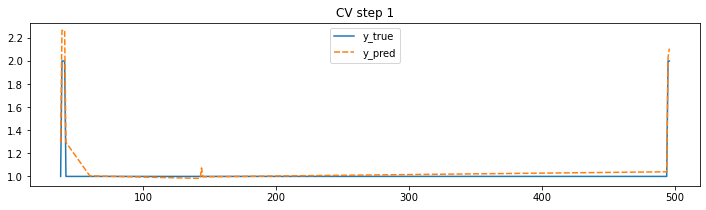

LGBM CV step 1 WAPE: 0.06945934716900029
2023-06-20 00:00:00 2023-07-04 00:00:00
(353739, 790) (16568, 790)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.990579
[200]	valid_0's l2: 0.802311
[300]	valid_0's l2: 0.757541
[400]	valid_0's l2: 0.735905
[500]	valid_0's l2: 0.716702
[600]	valid_0's l2: 0.703587
[700]	valid_0's l2: 0.695755
[800]	valid_0's l2: 0.684592
[900]	valid_0's l2: 0.679294
[1000]	valid_0's l2: 0.672822
[1100]	valid_0's l2: 0.667299
[1200]	valid_0's l2: 0.665892
[1300]	valid_0's l2: 0.661347
[1400]	valid_0's l2: 0.658017
[1500]	valid_0's l2: 0.654022
[1600]	valid_0's l2: 0.650169
[1700]	valid_0's l2: 0.648102
[1800]	valid_0's l2: 0.644325
[1900]	valid_0's l2: 0.64097
[2000]	valid_0's l2: 0.638661
[2100]	valid_0's l2: 0.635783
[2200]	valid_0's l2: 0.634802
[2300]	valid_0's l2: 0.631741
[2400]	valid_0's l2: 0.631752
[2500]	valid_0's l2: 0.631272
[2600]	valid_0's l2: 0.629664
[2700]	valid_0's l2: 0.628389
[2800]	valid_0's l2: 0.625856


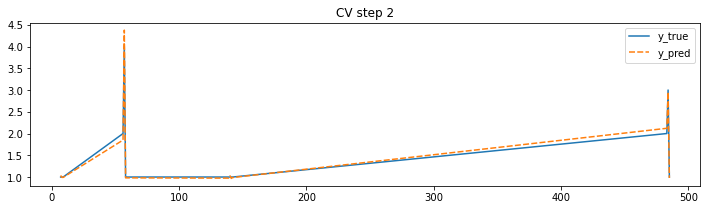

LGBM CV step 2 WAPE: 0.05747498385161258
2023-06-06 00:00:00 2023-06-20 00:00:00
(337483, 790) (16256, 790)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 1.51621
[200]	valid_0's l2: 1.72756
Early stopping, best iteration is:
[97]	valid_0's l2: 1.4948


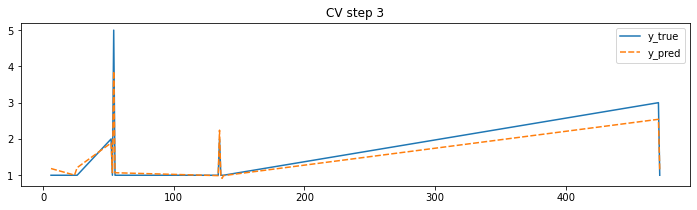

LGBM CV step 3 WAPE: 0.09463514996811768
2023-05-23 00:00:00 2023-06-06 00:00:00
(321717, 790) (15766, 790)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 1.06616
[200]	valid_0's l2: 0.933663
[300]	valid_0's l2: 0.882848
[400]	valid_0's l2: 0.86279
[500]	valid_0's l2: 0.839127
[600]	valid_0's l2: 0.821111
[700]	valid_0's l2: 0.804751
[800]	valid_0's l2: 0.796288
[900]	valid_0's l2: 0.793869
[1000]	valid_0's l2: 0.788628
[1100]	valid_0's l2: 0.78135
[1200]	valid_0's l2: 0.777097
[1300]	valid_0's l2: 0.772377
[1400]	valid_0's l2: 0.771483
[1500]	valid_0's l2: 0.768981
[1600]	valid_0's l2: 0.768255
[1700]	valid_0's l2: 0.765859
[1800]	valid_0's l2: 0.764257
[1900]	valid_0's l2: 0.760758
[2000]	valid_0's l2: 0.75862
[2100]	valid_0's l2: 0.757687
[2200]	valid_0's l2: 0.756837
[2300]	valid_0's l2: 0.756638
Early stopping, best iteration is:
[2174]	valid_0's l2: 0.756229


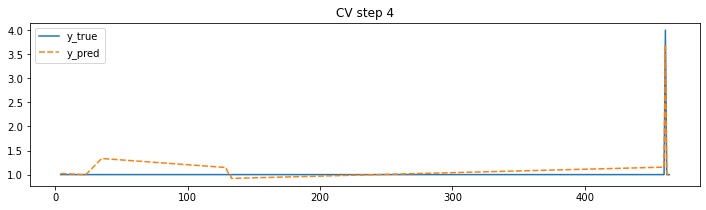

LGBM CV step 4 WAPE: 0.06736964872323352
2023-05-09 00:00:00 2023-05-23 00:00:00
(305868, 790) (15849, 790)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.608137
[200]	valid_0's l2: 0.514469
[300]	valid_0's l2: 0.476217
[400]	valid_0's l2: 0.465293
[500]	valid_0's l2: 0.458692
[600]	valid_0's l2: 0.451244
[700]	valid_0's l2: 0.4499
[800]	valid_0's l2: 0.441205
[900]	valid_0's l2: 0.438371
[1000]	valid_0's l2: 0.435742
[1100]	valid_0's l2: 0.431992
[1200]	valid_0's l2: 0.430567
[1300]	valid_0's l2: 0.42749
[1400]	valid_0's l2: 0.425837
[1500]	valid_0's l2: 0.425602
[1600]	valid_0's l2: 0.424907
[1700]	valid_0's l2: 0.422253
[1800]	valid_0's l2: 0.421735
[1900]	valid_0's l2: 0.42199
Early stopping, best iteration is:
[1762]	valid_0's l2: 0.420972


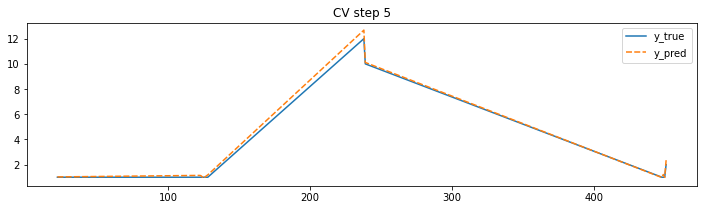

LGBM CV step 5 WAPE: 0.06539992194777991


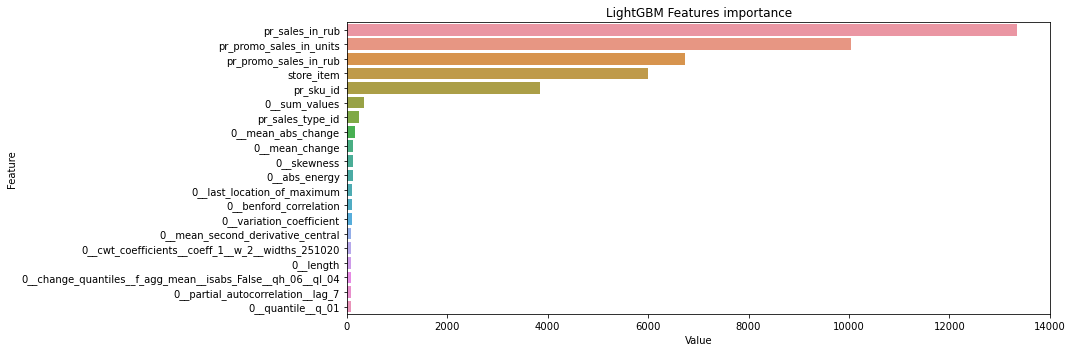

In [40]:
lgbm_wapes = lgbm_cross_val(df=df_fresh, cat_features=['store_item', 'pr_sku_id', 'st_id'],\
                            cols_to_drop=['pr_sales_in_units', 'date'])

In [41]:
print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

LGBM mean WAPE = 0.0708678103319488


In [72]:
# import pickle
# pkl_filename = "fresh_model.pkl" 
# with open(pkl_filename, 'wb') as file: 
#     pickle.dump(lgbm_reg, file) 

NameError: name 'lgbm_reg' is not defined

Результаты с 780 фичами сгенерированными EfficientFCParameters (датасет byproducts). <div>
    Итерация 1. 
* Фичи: Только то, что сгенерировал tsfresh.
* ВЭЙП: 0.5428495793143385
* Важное: товар, 0_sum_values, 0_abs_energy, 0_median, 0_agg_linear_trend_attr_intercept_chunk_len_50_f_agg_mean, 0_mean_change, 0_quantile_q_07, 0_mean_abs_change, 0_quantile_q_06, 0_fft_coefficient_attr_abs_coeff_97. <div>
    
    Итерация 2. <div>
* Фичи: Важные фичи из первой итерации и календарные.
* ВЭЙП: 0.44511336308301114
* Важное: week, dow, 0_sum_values, товар,0_median, 0_abs_energy, day/season практически не влияет. 

Результаты с лагами и MA.<div>
Итерация 1

* Фичи: товар, магазин, 21 лаг (Тлаг)
* ВЭЙП: 0.5387446485520166
* Важное: товар, Тлаг 1, магазин, Тлаги 14, 7, 2, 6, 12, 13, 5, 9

Итерация 2

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг)
* ВЭЙП: 0.542979568453861
* Важное: товар, Тлаги 1, 14, 7, магазин, Тлаг 6, Млаги 6, 7, 13, 14
* Вывод: стало хуже. Пока оставим магазинные лаги, но когда фичей будет больше, попробуем их убрать

Итерация 3

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг), календарные
* ВЭЙП: 0.5372880913031014
* Важное: товар, Тлаги 1, 14, магазин, день недели, Млаг 7, Тлаги 2, 7, Млаг 6, Тлаг 6, Млаг 13
* Вывод: метрика немного улучшилась. Календарные фичи нужны

In [ ]:
def objective(trial, data=with_store_lags, cols_to_drop=['date', 'sold', 'sku', 'store'], cat_features=['pr_sku_id', 'st_id', 'season', 'dow']):
    
    end_train = data['date'].max() - pd.Timedelta(days=14)
    train = data[data['date'] <= end_train]
    valid = data[data['date'] > end_train]

    train_x = train.drop(cols_to_drop, axis=1)
    train_y = train['sold']
    test_x = valid.drop(cols_to_drop, axis=1)
    test_y = valid['sold']

    cat_idx = [train_x.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        train_x[col] = pd.Categorical(train_x[col])
        test_x[col] = pd.Categorical(test_x[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,categorical_feature=cat_idx,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)

    trial.set_user_attr(key="best_booster", value=model)
    
    return wape(test_y, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
data=with_store_lags
cols_to_drop=['date', 'sold', 'sku', 'store']
cat_features=['pr_sku_id', 'st_id', 'season', 'dow']

end_train = data['date'].max() - pd.Timedelta(days=14)
train = data[data['date'] <= end_train]
valid = data[data['date'] > end_train]

X_train = train.drop(cols_to_drop, axis=1)
y_train = train['sold']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['sold']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

Здесь сохраняется та же логика кросс-валидации, которую мы применяли для предыдущей модели: мы выделили в качестве валидационной выборки последние 14 дней, оставив все предшествующие данные в обучающей выборке. Для второго фолда кросс-валидации мы сдвинули валидационную выборку на две недели раньше, тем самым на 14 дней сократив обучающую. Таким образом мы в цикле последовательно формируем 5 фолдов кросс-валидации, обучаем на хронологически первых данных градиентный бустинг, валидируем его на последних 14 днях и оцениваем важность признаков в порядке от наиболее к наименее важным. По изменениям метрики и графику важности признаков мы оцениваем признаки, добавленные в данной итерации. Наблюдения за процессом записаны в ячейке под обучением

Наиболее важным представляется категориальный признак товар, затем его продажи вчера и позавчера. Это кажется логичным: прогноз основывается на том, как товар обычно продается, как продавался в последние дни. Важны лаги, кратные 7, что указывает на сильную недельную сезонность. На самом деле это даже может быть проблемой: когда мы смотрим на графики прогнозов нашей модели, мы мало что видим, кроме двух небольших пиков в выходные. Продажи магазина кажутся менее значимыми, чем продажи товара по всем магазинам, однако вчерашние продажи магазина и продажи неделю назад все же вошли в топ. Из календарных признаков важны день месяца и номер недели - есть тренд и месячная сезонность

### Forecasting

In [ ]:
#get lines from submission form
updated_sub = pd.read_csv('updated_sub.csv')
updated_sub['date'] = pd.to_datetime(updated_sub['date']).dt.normalize()
updated_sub['store_item'] = updated_sub['st_id'].str.cat(updated_sub['pr_sku_id'], sep='-')
updated_sub.head()

In [ ]:
#take only those lines we didn't fill in the previous part
nonflagman_sub = updated_sub[updated_sub['target'].isna()]
nonflagman_sub.shape

In [ ]:
#make sure there are 14-days forecast periods for each of item-store pairs
nonflagman_sub['store_item'].nunique() * 14

In [ ]:
def preprocess_test_by_sku(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags - sku
    pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['sku_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'sku_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'sku']

    #add features of day-of-week, day-of-month, week, month, season
    pred_with_history['dow'] = pred_with_history['date'].dt.dayofweek
    pred_with_history['day'] = pred_with_history['date'].dt.day
    pred_with_history['week'] = pred_with_history['date'].dt.isocalendar().week.astype('int32')
    pred_with_history['month'] = pred_with_history['date'].dt.month
    pred_with_history['season'] = pred_with_history['date'].dt.quarter    
    
    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [ ]:
def preprocess_test_by_store(pred_with_history):    
    #index needs to be reset, as for non-first lines in a forecast they are equal
    pred_with_history = pred_with_history.reset_index(drop=True)

    #add lags - store
    pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]].fillna(method='ffill')
    pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]] = pred_with_history[['store_lag_' + str(n) for n in range(1, 22)]].shift(1, axis=1)
    pred_with_history.loc[pred_with_history.index[-1], 'store_lag_1'] = pred_with_history.loc[pred_with_history.index[0], 'store']
    
    #drop upper row
    pred_with_history = pred_with_history.drop(pred_with_history.index[0], axis=0)    

    return(pred_with_history)

In [ ]:
#this is what we'll get as input
nonflagman_sub = nonflagman_sub.drop('store_item', axis=1)
first_pred = nonflagman_sub[nonflagman_sub['date'] == nonflagman_sub['date'].min()].head(1)
first_pred

In [ ]:
def make_forecast_for_sample_row(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        #if first line take lags from the last line of train. otherwise from previous predicted line
        #first match sku to get sku lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['pr_sku_id'] == lower_row['pr_sku_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])        
        sku_preprocessed = preprocess_test_by_sku(pred_with_history)

        #now match store to get store lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['st_id'] == lower_row['st_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, sku_preprocessed])        
        last_preprocessed = preprocess_test_by_store(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['date', 'sold', 'sku', 'store', 'target'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

make_forecast_for_sample_row(first_pred)

In [ ]:
#lets fill submission file with forecasts. na sum shows how many values are left
updated_sub.isna().sum()

In [ ]:
#here are pairs we're going to predict with this model
nonflagman_sub = nonflagman_sub.groupby(['st_id', 'pr_sku_id'])['date'].min().reset_index()
nonflagman_sub.head()

In [ ]:
nonflagman_sub.shape

In [ ]:
common_forecast = pd.DataFrame()
for index, row in nonflagman_sub.iterrows():
    try:
        forecast = make_forecast_for_sample_row(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))    
        common_forecast = pd.concat([common_forecast, forecast])
    except:
        continue
    

In [ ]:
#check that there are 14 days of forecast for each pair of 2341
common_forecast.date.value_counts()

In [ ]:
#update submission
updated_sub = updated_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
updated_sub.isna().sum()

In [ ]:
#return to original columns
new_updated_sub = updated_sub.copy()
new_updated_sub['isna_sum'] = new_updated_sub.isna().sum(axis=1)
new_updated_sub['target_x'] = new_updated_sub[['target_x', 'target_y']].sum(axis=1)
new_updated_sub = new_updated_sub.rename(columns={'target_x': 'target'}).drop(['target_y', 'store_item'], axis=1)
new_updated_sub['target'] = new_updated_sub.apply(lambda x: np.nan if x['isna_sum'] == 2 else x['target'], axis=1)
new_updated_sub.isna().sum()

У нас осталось достаточно много незаполненных строк. Это строки, попавшие при прогнозе в исключение - для товаров не нашлись данные в последний день обучающей выборки, 2023-07-18. Подтянем для них временные ряды, ранее заполненные нулями. Для этого необходимо изменить функцию прогноза

In [ ]:
def make_last_forecast(line_from_submission, h=14):
    forecast = pd.DataFrame()
    row = line_from_submission.copy()
    start_date = row['date']
    
    for i in range(h):
        row['date'] = start_date + pd.Timedelta(days=1*i)
        lower_row = row.copy()

        #this is what we change. look for lags not in train dataset, but in byproduct where we filled missing days with zeros
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = byproduct[(byproduct['pr_sku_id'] == lower_row['pr_sku_id'].item()) & 
                                        (byproduct['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, lower_row])        
        sku_preprocessed = preprocess_test_by_sku(pred_with_history)

        #now match store to get store lags
        if i == 0:
            last_train_date = with_store_lags['date'].max()
            upper_row = with_store_lags[(with_store_lags['st_id'] == lower_row['st_id'].item()) & 
                                        (with_store_lags['date'] == last_train_date)].head(1)
        else:
            upper_row = last_preprocessed
        
        #glue two lines together, the full and the empty that needs features to be added
        pred_with_history = pd.concat([upper_row, sku_preprocessed])        
        last_preprocessed = preprocess_test_by_store(pred_with_history)
        
        #drop columns before model
        X_test = last_preprocessed.drop(['date', 'sold', 'sku', 'store', 'target'], axis=1)

        #fix categorical
        for col in cat_features:
            X_test[col] = pd.Categorical(X_test[col])
            
        pred = lgbm_reg.predict(X_test)

        #prediction becomes "fact" of the day we forecast to become lag_1 for the next day. also it goes to forecast table as target
        last_preprocessed['sold'] = round(pred.item())
        row['target'] = round(pred.item())
        
        forecast = pd.concat([forecast, row])
        
    return forecast

In [ ]:
#form dataset for which forecast is not filled
rare_sku_sub = new_updated_sub[new_updated_sub['target'].isna()]
rare_sku_sub = rare_sku_sub.groupby(['st_id', 'pr_sku_id'])['date'].min().reset_index()
rare_sku_sub.head()

In [ ]:
rare_sku_sub.shape, 8092 / 14

In [ ]:
common_forecast = pd.DataFrame()
for index, row in rare_sku_sub.iterrows():
    try:
        forecast = make_last_forecast(pd.DataFrame({'st_id': row['st_id'], 'pr_sku_id': row['pr_sku_id'], 'date': row['date'], 'target': np.nan}, index=[0]))    
        common_forecast = pd.concat([common_forecast, forecast])    
    except:
        continue

In [ ]:
#check that there are 14 days of forecast for each pair of remaining 578
common_forecast.date.value_counts()

In [ ]:
#update submission
new_updated_sub = new_updated_sub.merge(common_forecast, on=['st_id', 'pr_sku_id', 'date'], how='left')
new_updated_sub.isna().sum()

In [ ]:
#return to original columns
last_updated_sub = new_updated_sub.copy()
last_updated_sub['isna_sum'] = last_updated_sub.isna().sum(axis=1)
last_updated_sub['target_x'] = last_updated_sub[['target_x', 'target_y']].sum(axis=1)
last_updated_sub = last_updated_sub.rename(columns={'target_x': 'target'}).drop(['target_y'], axis=1)
last_updated_sub['target'] = last_updated_sub.apply(lambda x: np.nan if x['isna_sum'] == 2 else x['target'], axis=1)
last_updated_sub.isna().sum()

In [ ]:
last_updated_sub = last_updated_sub.fillna(0).drop('isna_sum', axis=1)
last_updated_sub.isna().sum()

In [ ]:
#save to csv
last_updated_sub.to_csv('submission.csv', index=False)

Эту часть мы планируем улучшить, однако в целях облегчения ревью опишем, что происходит в ней сейчас:

1) мы выделяем в датасет nonflagman_sub пары товар-магазин, для которых создана эта модель модель, не вошедшие в топ и с разреженными временными рядами

2) для каждой строки из тестовой выборки необходимо создать фичи по образу обучающей выборки. Здесь есть отличие от предыдущей модели. К каждой строке мы отдельно подбираем данные по товару и по магазину в предыдущий день (не по паре товар-магазин, как в первой модели). Если речь идет о первом дне прогноза, данные берем из последнего дня обучающей выборки. Для дней прогноза со 2 по 14 основанием для создания лагов и скользящих средних является предыдущая строка прогноза. Предобработка столбцов задана в функции preprocess_test. Функция make_forecast_for_sample_row принимает на вход строку из списка целевых пар и выдает датафрейм прогноза на 14 дней

3) мы итерируемся по списку пар товар-магазин и, выводя прогноз для каждой из них, конкатенируем их в единый датафрейм

4) соединяем датафрейм submission с полученным прогнозом, заполняя часть значений в столбце target

5) если в первой модели мы на этом закончили, то здесь мы сталкиваемся с проблемой: у нас остались незаполненные строки прогноза. Это связано с тем, что не все фичи для тестовых строк удалось заполнить. Данные о продажах по магазину за вчера есть для всех пар, чего нельзя сказать о данных по товару. Некоторые товары не продавались в последний день обучающего датасета ни в одном магазине. Для таких случаев мы обращаемся к ранее созданному датасету byproduct, в котором разреженные временные ряды заполнены нулями. Возможно, нам следует сделать это сразу, сняв необходимость этой второй итерации

6) однако и после этого информация о порядка 100 товаров не была найдена - проверяем в исходном датасете sales: это товары, которые не продавались никогда и нигде. Прогноз продаж новых товаров - это отдельная сложная задача, вернемся к ней позже. Пока для простоты будем считать, что если что-то никогда не пользовалось спросом, то нет оснований полагать, что завтра вдруг начнем, и заполним эти строки нулями.

### to do

* закончить процесс формирования признаков для второй модели

* экспериментировать с разбивкой второй модели по кластерам

* попробовать другие алгоритмы ML, кроме градиентного бустинга

* использовать модели типа Аримы/Профета для прогноза цены вместо заглушки

* проработать проблему прогнозирования спроса на новые товары

* сделать кросс-валидацию 14-шаговой в соответствии с алгоритмом прогнозирования

* рассмотреть варианты рефакторинга алгоритма прогнозирования

* упаковать полученную модель (модели) в docker контейнер